# Chapter 19: Code optimization

Robert Johansson

Source code listings for [Numerical Python - Scientific Computing and Data Science Applications with Numpy, SciPy and Matplotlib](https://link.springer.com/book/10.1007/979-8-8688-0413-7) (ISBN 979-8-8688-0412-0).

In [1]:
import numba

In [3]:
import pyximport

In [4]:
import cython

In [5]:
import numpy as np

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Numba

In [7]:
np.random.seed(0)

In [8]:
data = np.random.randn(50000)

In [9]:
def py_sum(data):
    s = 0
    for d in data:
        s += d
    return s

In [10]:
def py_cumsum(data):
    out = np.zeros(len(data), dtype=np.float64)
    s = 0
    for n in range(len(data)):
        s += data[n]
        out[n] = s

    return out

In [11]:
%timeit py_sum(data)

2.81 ms ± 78.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
assert abs(py_sum(data) - np.sum(data)) < 1e-10

In [13]:
%timeit np.sum(data)

9.92 μs ± 118 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [14]:
%timeit py_cumsum(data)

5.7 ms ± 39 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
assert np.allclose(np.cumsum(data), py_cumsum(data))

In [16]:
%timeit np.cumsum(data)

106 μs ± 1.64 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
@numba.jit
def jit_sum(data):
    s = 0
    for d in data:
        s += d

    return s

In [18]:
assert abs(jit_sum(data) - np.sum(data)) < 1e-10

In [19]:
%timeit jit_sum(data)

22.5 μs ± 123 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
jit_cumsum = numba.jit()(py_cumsum)

In [21]:
assert np.allclose(np.cumsum(data), jit_cumsum(data))

In [22]:
%timeit jit_cumsum(data)

31.3 μs ± 1.18 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Julia fractal

In [23]:
def py_julia_fractal(z_re, z_im, j):
    for m in range(len(z_re)):
        for n in range(len(z_im)):
            z = z_re[m] + 1j * z_im[n]
            for t in range(256):
                z = z**2 - 0.05 + 0.68j
                if np.abs(z) > 2.0:
                    # if (z.real * z.real + z.imag * z.imag) > 4.0:  # a bit faster
                    j[m, n] = t
                    break

In [24]:
jit_julia_fractal = numba.jit(nopython=True)(py_julia_fractal)

In [25]:
N = 1024
j = np.zeros((N, N), np.int64)
z_real = np.linspace(-1.5, 1.5, N)
z_imag = np.linspace(-1.5, 1.5, N)

In [26]:
jit_julia_fractal(z_real, z_imag, j)

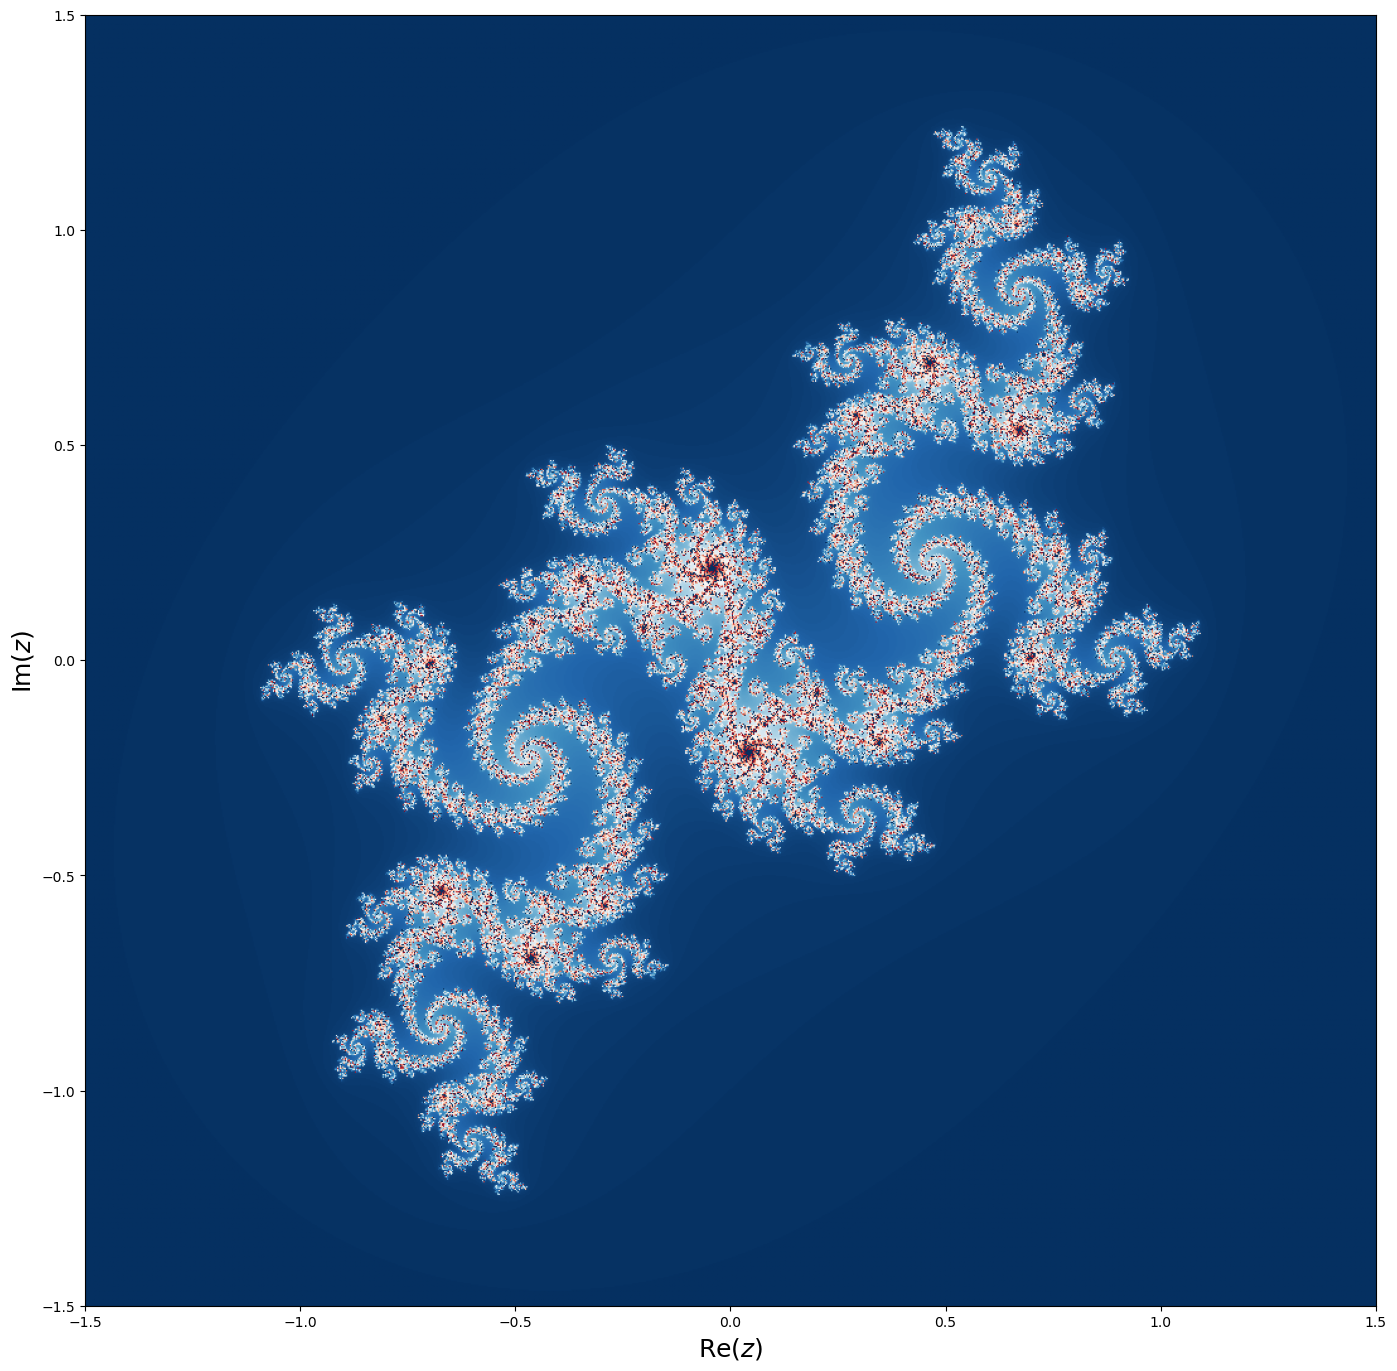

In [27]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(j, cmap=plt.cm.RdBu_r, extent=[-1.5, 1.5, -1.5, 1.5])
ax.set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
ax.set_ylabel("$\mathrm{Im}(z)$", fontsize=18)
fig.tight_layout()
fig.savefig("ch19-numba-julia-fractal.pdf")

In [28]:
%timeit py_julia_fractal(z_real, z_imag, j)

15.9 s ± 481 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit jit_julia_fractal(z_real, z_imag, j)

141 ms ± 633 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Vectorize

In [30]:
def py_Heaviside(x):
    if x == 0.0:
        return 0.5

    if x < 0.0:
        return 0.0
    else:
        return 1.0

In [31]:
x = np.linspace(-2, 2, 50001)

In [32]:
%timeit [py_Heaviside(xx) for xx in x]

3.99 ms ± 51.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
np_vec_Heaviside = np.vectorize(py_Heaviside)

In [34]:
np_vec_Heaviside(x)

array([0., 0., 0., ..., 1., 1., 1.], shape=(50001,))

In [35]:
%timeit np_vec_Heaviside(x)

5.38 ms ± 61.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
def np_Heaviside(x):
    return (x > 0.0) + (x == 0.0) / 2.0

In [37]:
%timeit np_Heaviside(x)

69 μs ± 715 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [38]:
@numba.vectorize([numba.float32(numba.float32), numba.float64(numba.float64)])
def jit_Heaviside(x):
    if x == 0.0:
        return 0.5

    if x < 0:
        return 0.0
    else:
        return 1.0

In [39]:
%timeit jit_Heaviside(x)

9.93 μs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [40]:
jit_Heaviside([-1, -0.5, 0.0, 0.5, 1.0])

array([0. , 0. , 0.5, 1. , 1. ])

# Cython

In [41]:
!rm cy_sum.*

zsh:1: no matches found: cy_sum.*


In [42]:
%%writefile cy_sum.pyx

def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

Writing cy_sum.pyx


In [43]:
!cython cy_sum.pyx

In [44]:
# 5 lines of python code -> 1470 lines of C code ...
!wc cy_sum.c

  7793  25359 305330 cy_sum.c


In [45]:
%%writefile setup.py

from distutils.core import setup
from Cython.Build import cythonize

import numpy as np
setup(ext_modules=cythonize('cy_sum.pyx'),
      include_dirs=[np.get_include()],
      requires=['Cython', 'numpy'] )

Writing setup.py


In [48]:
!python setup.py build_ext --inplace > /dev/null

In [49]:
from cy_sum import cy_sum

In [50]:
cy_sum(data)

np.float64(-189.70046227549025)

In [51]:
%timeit cy_sum(data)

2.61 ms ± 19.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%timeit py_sum(data)

2.9 ms ± 51.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
%%writefile cy_cumsum.pyx

cimport numpy
import numpy

def cy_cumsum(data):
    out = numpy.zeros_like(data)
    s = 0 
    for n in range(len(data)):
        s += data[n]
        out[n] = s

    return out

Writing cy_cumsum.pyx


In [54]:
pyximport.install(setup_args={"include_dirs": np.get_include()});

In [55]:
pyximport.install(setup_args=dict(include_dirs=np.get_include()));

In [56]:
from cy_cumsum import cy_cumsum

In [57]:
%timeit cy_cumsum(data)

5.81 ms ± 44.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
%timeit py_cumsum(data)

5.69 ms ± 108 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Using IPython cython command

In [59]:
%load_ext cython

In [60]:
%%cython -a
def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

In [61]:
%timeit cy_sum(data)

2.76 ms ± 11.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
%timeit py_sum(data)

2.96 ms ± 22.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
assert np.allclose(np.sum(data), cy_sum(data))

In [64]:
%%cython -a
cimport numpy
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_sum(numpy.ndarray[numpy.float64_t, ndim=1] data):
    cdef numpy.float64_t s = 0.0
    #cdef int n, N = data.shape[0]
    cdef int n, N = len(data)
    for n in range(N):
        s += data[n]
    return s

In [65]:
%timeit cy_sum(data)

22.4 μs ± 256 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [66]:
%timeit jit_sum(data)

22.2 μs ± 998 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [67]:
%timeit np.sum(data)

10.3 μs ± 179 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Cummulative sum

In [68]:
%%cython -a
cimport numpy
import numpy
cimport cython

ctypedef numpy.float64_t FTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_cumsum(numpy.ndarray[FTYPE_t, ndim=1] data):
    cdef int n, N = data.size
    cdef numpy.ndarray[FTYPE_t, ndim=1] out = numpy.zeros(N, dtype=data.dtype)
    cdef numpy.float64_t s = 0.0
    for n in range(N):
        s += data[n]
        out[n] = s
    return out

In [69]:
%timeit py_cumsum(data)

5.92 ms ± 126 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
%timeit cy_cumsum(data)

30.4 μs ± 701 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [71]:
%timeit jit_cumsum(data)

30.6 μs ± 887 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [72]:
%timeit np.cumsum(data)

108 μs ± 1.63 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [73]:
assert np.allclose(cy_cumsum(data), np.cumsum(data))

## Fused types

In [74]:
py_sum([1.0, 2.0, 3.0, 4.0, 5.0])

15.0

In [75]:
py_sum([1, 2, 3, 4, 5])

15

In [ ]:
cy_sum(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))

15.0

In [79]:
cy_sum(np.array([1, 2, 3, 4, 5], dtype=np.float64))

15.0

In [80]:
%%cython -a
cimport numpy
cimport cython

ctypedef fused I_OR_F_t:
    numpy.int64_t 
    numpy.float64_t 

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_fused_sum(numpy.ndarray[I_OR_F_t, ndim=1] data):
    cdef I_OR_F_t s = 0
    cdef int n, N = data.size
    for n in range(N):
        s += data[n]
    return s

In [81]:
cy_fused_sum(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))

15.0

In [82]:
cy_fused_sum(np.array([1, 2, 3, 4, 5]))

15

## Julia fractal

In [83]:
%%cython -a
cimport numpy
cimport cython

ctypedef numpy.int64_t ITYPE_t
ctypedef numpy.float64_t FTYPE_t

cpdef inline double abs2(double complex z):
    return z.real * z.real + z.imag * z.imag

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_julia_fractal(numpy.ndarray[FTYPE_t, ndim=1] z_re, 
                     numpy.ndarray[FTYPE_t, ndim=1] z_im, 
                     numpy.ndarray[ITYPE_t, ndim=2] j):
    cdef int m, n, t, M = z_re.size, N = z_im.size
    cdef double complex z
    for m in range(M):
        for n in range(N):
            z = z_re[m] + 1.0j * z_im[n]
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j
                if abs2(z) > 4.0:
                    j[m, n] = t
                    break

In [84]:
N = 1024

In [85]:
j = np.zeros((N, N), dtype=np.int64)

In [86]:
z_real = np.linspace(-1.5, 1.5, N)

In [87]:
z_imag = np.linspace(-1.5, 1.5, N)

In [88]:
%timeit cy_julia_fractal(z_real, z_imag, j)

1.83 s ± 51.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
%timeit jit_julia_fractal(z_real, z_imag, j)

133 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [90]:
j1 = np.zeros((N, N), dtype=np.int64)

In [91]:
cy_julia_fractal(z_real, z_imag, j1)

In [92]:
j2 = np.zeros((N, N), dtype=np.int64)

In [93]:
jit_julia_fractal(z_real, z_imag, j2)

In [94]:
# assert np.allclose(j1, j2)

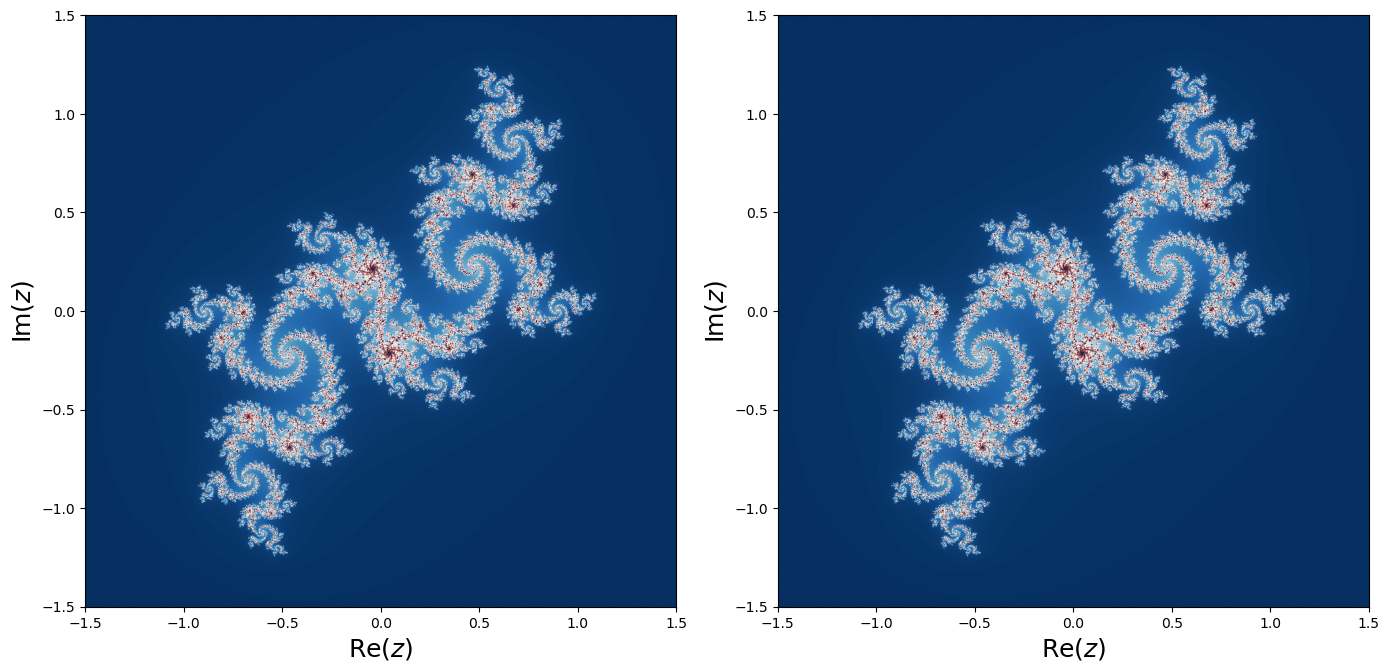

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(14, 14))
axes[0].imshow(j1, cmap=plt.cm.RdBu_r, extent=[-1.5, 1.5, -1.5, 1.5])
axes[0].set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
axes[0].set_ylabel("$\mathrm{Im}(z)$", fontsize=18)
axes[1].imshow(j2, cmap=plt.cm.RdBu_r, extent=[-1.5, 1.5, -1.5, 1.5])
axes[1].set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
axes[1].set_ylabel("$\mathrm{Im}(z)$", fontsize=18)
fig.tight_layout()

## Calling C function

In [96]:
%%cython

cdef extern from "math.h":
     double acos(double)

def cy_acos1(double x):
    return acos(x)

In [97]:
%timeit cy_acos1(0.5)

31.7 ns ± 0.342 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [98]:
%%cython

from libc.math cimport acos

def cy_acos2(double x):
    return acos(x)

In [99]:
%timeit cy_acos2(0.5)

31.6 ns ± 0.542 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [100]:
from numpy import arccos

In [101]:
%timeit arccos(0.5)

73.5 ns ± 0.94 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [102]:
from math import acos

In [103]:
%timeit acos(0.5)

29.8 ns ± 0.296 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [104]:
assert cy_acos1(0.5) == acos(0.5)

In [105]:
assert cy_acos2(0.5) == acos(0.5)